# Network Analysis of Zachary's Karate Club: Centrality, Community Structure, and Attribute-Based Clustering

**Project:** Analysis of social network data using network science methods  
**Dataset:** Zachary Karate Club Network  
**Date:** 2025



## 1. Background / Introduction

Zachary's Karate Club is a classic network analysis dataset that represents the social relationships among 34 members of a karate club at a US university in the 1970s. Over the course of the study, the club split into two factions due to a conflict between the club's administrator and the instructor.

**Key Questions:**
- Which members were most central in the network?
- How do detected communities align with the actual split that occurred?
- Can we identify the two factions using network analysis methods?

This analysis will explore:
- **Centrality measures**: degree, betweenness, and closeness centrality
- **Community detection**: Louvain algorithm and Girvan-Newman method
- **Attribute-based clustering**: KMeans clustering on node features
- **Dimensionality reduction**: MDS and t-SNE visualization



## 2. Research Question

**Primary Research Question:** Which members were most central in the network, and how do detected communities align with the real split that occurred?

This question will be addressed through:
1. Computing multiple centrality measures to identify key individuals
2. Applying community detection algorithms to partition the network
3. Comparing detected communities with the known faction split
4. Analyzing node attributes and structural features



## 3. Data Loading & Description


In [1]:
import sys
import os
sys.path.append('../src')

import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json

# Import custom modules
from load_data import load_graph, load_metadata
from centrality import compute_all_centralities, get_top_central_nodes
from communities import louvain_communities, girvan_newman_communities, compute_modularity
from clustering import prepare_node_features, kmeans_clustering, hierarchical_clustering, create_clustering_dict
from visualization import plot_network, plot_by_communities, plot_embedding, compute_mds_embedding, compute_tsne_embedding
from utils import get_node_attributes, attribute_to_numeric

# Set style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid')
    except OSError:
        plt.style.use('ggplot')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load the Zachary Karate Club graph
G, metadata = load_graph(source='networkx')

print(f"Dataset: {metadata.get('dataset', 'Zachary Karate Club')}")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Density: {nx.density(G):.4f}")
print(f"Is connected: {nx.is_connected(G)}")
print(f"\nDescription: {metadata.get('description', '')}")


Dataset: Zachary Karate Club
Number of nodes: 34
Number of edges: 78
Density: 0.1390
Is connected: True

Description: 


In [3]:
# Get the club attribute (the known faction split)
club_attribute = get_node_attributes(G, 'club')

# Convert to numeric (0 = Mr. Hi, 1 = Officer)
club_mapping = {'Mr. Hi': 0, 'Officer': 1}
club_numeric = attribute_to_numeric(club_attribute, mapping=club_mapping)

print("Club faction distribution:")
print(f"Mr. Hi faction: {Counter(club_attribute.values())['Mr. Hi']} members")
print(f"Officer faction: {Counter(club_attribute.values())['Officer']} members")

# Display first few nodes with their club membership
print("\nSample nodes and their faction:")
for node in sorted(G.nodes())[:10]:
    print(f"Node {node}: {club_attribute.get(node, 'Unknown')}")


Club faction distribution:
Mr. Hi faction: 17 members
Officer faction: 17 members

Sample nodes and their faction:
Node 0: Mr. Hi
Node 1: Mr. Hi
Node 2: Mr. Hi
Node 3: Mr. Hi
Node 4: Mr. Hi
Node 5: Mr. Hi
Node 6: Mr. Hi
Node 7: Mr. Hi
Node 8: Mr. Hi
Node 9: Officer


In [4]:
# Basic network statistics
print("Network Statistics:")
print(f"- Nodes: {G.number_of_nodes()}")
print(f"- Edges: {G.number_of_edges()}")
print(f"- Average degree: {2 * G.number_of_edges() / G.number_of_nodes():.2f}")
print(f"- Clustering coefficient: {nx.average_clustering(G):.4f}")
print(f"- Diameter: {nx.diameter(G)}")
print(f"- Average path length: {nx.average_shortest_path_length(G):.4f}")


Network Statistics:
- Nodes: 34
- Edges: 78
- Average degree: 4.59
- Clustering coefficient: 0.5706
- Diameter: 5
- Average path length: 2.4082


## 4. Computation of Centrality Measures

We compute three centrality measures to identify the most important nodes:
- **Degree Centrality**: Number of connections a node has
- **Betweenness Centrality**: How often a node lies on the shortest path between other nodes
- **Closeness Centrality**: Average distance from a node to all other nodes


In [5]:
# Compute all centrality measures
centralities_df = compute_all_centralities(G)

# Display results
print("Centrality Measures Summary:")
print(centralities_df.describe())

print("\nTop 10 nodes by each centrality measure:")
print("\n=== Degree Centrality ===")
top_degree = get_top_central_nodes(dict(zip(centralities_df['node'], centralities_df['degree_centrality'])), n=10)
for node, score in top_degree:
    print(f"Node {node}: {score:.4f}")

print("\n=== Betweenness Centrality ===")
top_betweenness = get_top_central_nodes(dict(zip(centralities_df['node'], centralities_df['betweenness_centrality'])), n=10)
for node, score in top_betweenness:
    print(f"Node {node}: {score:.4f}")

print("\n=== Closeness Centrality ===")
top_closeness = get_top_central_nodes(dict(zip(centralities_df['node'], centralities_df['closeness_centrality'])), n=10)
for node, score in top_closeness:
    print(f"Node {node}: {score:.4f}")


Centrality Measures Summary:
            node  degree_centrality  betweenness_centrality  \
count  34.000000          34.000000               34.000000   
mean   16.500000           0.139037                0.044006   
std     9.958246           0.117509                0.093935   
min     0.000000           0.030303                0.000000   
25%     8.250000           0.060606                0.000000   
50%    16.500000           0.090909                0.002566   
75%    24.750000           0.151515                0.031853   
max    33.000000           0.515152                0.437635   

       closeness_centrality  
count             34.000000  
mean               0.426480  
std                0.072092  
min                0.284483  
25%                0.371840  
50%                0.383721  
75%                0.480168  
max                0.568966  

Top 10 nodes by each centrality measure:

=== Degree Centrality ===
Node 33: 0.5152
Node 0: 0.4848
Node 32: 0.3636
Node 2: 0.3030
No

In [6]:
# Create centrality dictionaries for visualization
degree_dict = dict(zip(centralities_df['node'], centralities_df['degree_centrality']))
betweenness_dict = dict(zip(centralities_df['node'], centralities_df['betweenness_centrality']))
closeness_dict = dict(zip(centralities_df['node'], centralities_df['closeness_centrality']))

# Normalize for node sizes
from utils import normalize_dict
degree_norm = normalize_dict(degree_dict)
node_sizes = {node: 300 + degree_norm[node] * 700 for node in G.nodes()}


Top 3 most central nodes (by degree): [33, 0, 32]


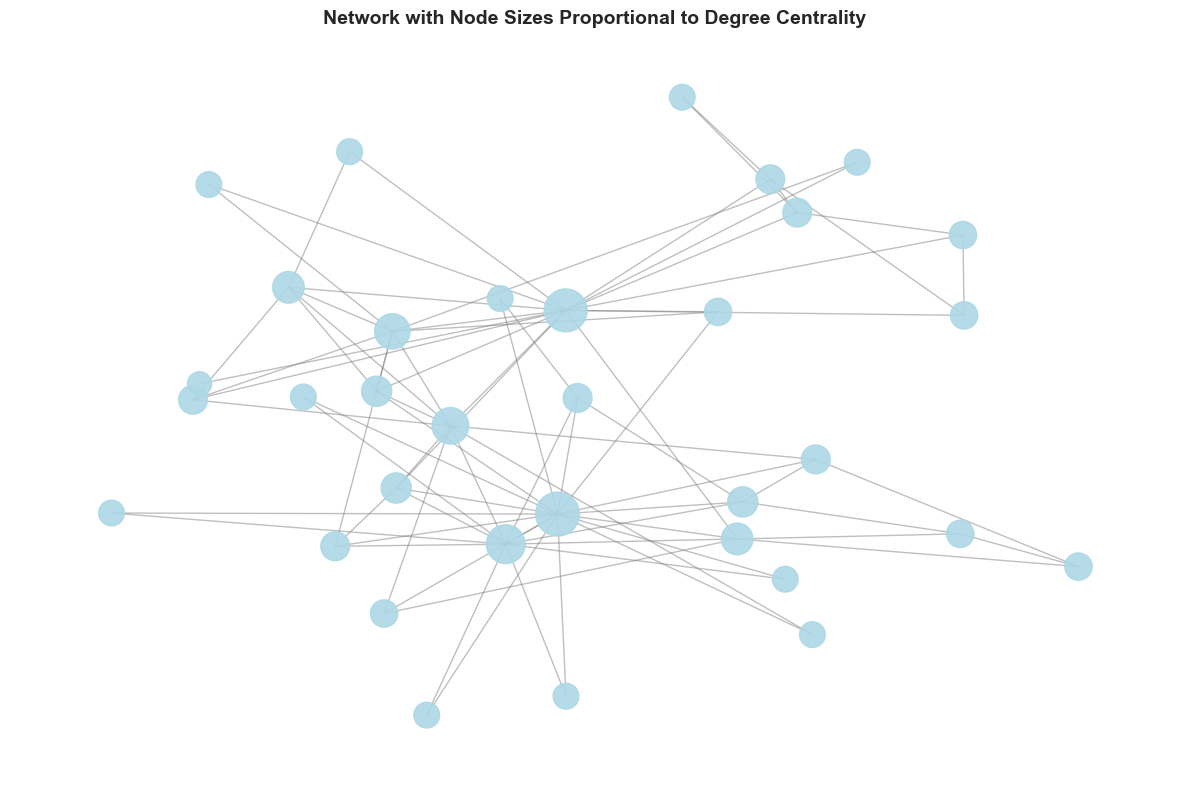

In [7]:
# Visualize network with node sizes proportional to degree centrality
fig, ax, pos = plot_network(G, node_sizes=node_sizes, 
                             title="Network with Node Sizes Proportional to Degree Centrality",
                             node_labels=False)

# Highlight top 3 most central nodes by degree
top_3_nodes = [node for node, _ in top_degree[:3]]
print(f"Top 3 most central nodes (by degree): {top_3_nodes}")

plt.show()


## 5. Community Detection

We apply two community detection algorithms:
- **Louvain Algorithm**: Modularity-based greedy optimization
- **Girvan-Newman Algorithm**: Hierarchical edge removal based on betweenness


In [9]:
# Louvain community detection
louvain_partition, louvain_modularity = louvain_communities(G)

print(f"Louvain Algorithm Results:")
print(f"Number of communities detected: {len(set(louvain_partition.values()))}")
print(f"Modularity: {louvain_modularity:.4f}")

# Display community assignments
community_counts = Counter(louvain_partition.values())
print(f"\nCommunity sizes: {dict(community_counts)}")

# Compare with actual club split
print("\n=== Comparison with Actual Split ===")
for comm_id in sorted(set(louvain_partition.values())):
    nodes_in_comm = [node for node, comm in louvain_partition.items() if comm == comm_id]
    mr_hi_count = sum(1 for node in nodes_in_comm if club_attribute.get(node) == 'Mr. Hi')
    officer_count = sum(1 for node in nodes_in_comm if club_attribute.get(node) == 'Officer')
    print(f"\nCommunity {comm_id} ({len(nodes_in_comm)} nodes):")
    print(f"  Mr. Hi faction: {mr_hi_count}")
    print(f"  Officer faction: {officer_count}")
    print(f"  Purity: {max(mr_hi_count, officer_count) / len(nodes_in_comm):.2%}")


Louvain Algorithm Results:
Number of communities detected: 4
Modularity: 0.4449

Community sizes: {0: 11, 2: 5, 3: 12, 1: 6}

=== Comparison with Actual Split ===

Community 0 (11 nodes):
  Mr. Hi faction: 11
  Officer faction: 0
  Purity: 100.00%

Community 1 (6 nodes):
  Mr. Hi faction: 0
  Officer faction: 6
  Purity: 100.00%

Community 2 (5 nodes):
  Mr. Hi faction: 5
  Officer faction: 0
  Purity: 100.00%

Community 3 (12 nodes):
  Mr. Hi faction: 1
  Officer faction: 11
  Purity: 91.67%


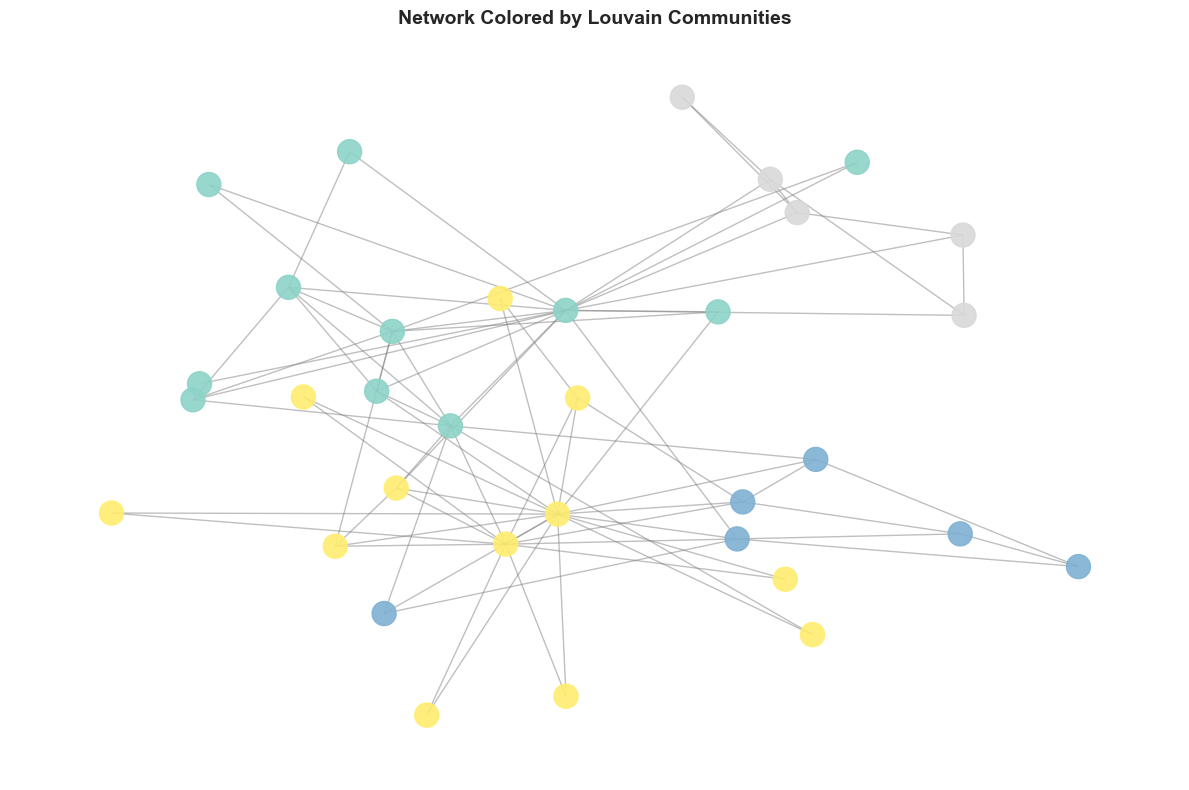

In [10]:
# Visualize Louvain communities
fig, ax, pos = plot_by_communities(G, louvain_partition, 
                                    title="Network Colored by Louvain Communities")
plt.show()


In [11]:
# Girvan-Newman community detection (2 communities)
girvan_newman_partition = girvan_newman_communities(G, num_communities=2)
girvan_modularity = compute_modularity(G, girvan_newman_partition)

print(f"Girvan-Newman Algorithm Results:")
print(f"Number of communities detected: {len(set(girvan_newman_partition.values()))}")
print(f"Modularity: {girvan_modularity:.4f}")

# Display community assignments
community_counts = Counter(girvan_newman_partition.values())
print(f"\nCommunity sizes: {dict(community_counts)}")

# Compare with actual club split
print("\n=== Comparison with Actual Split ===")
for comm_id in sorted(set(girvan_newman_partition.values())):
    nodes_in_comm = [node for node, comm in girvan_newman_partition.items() if comm == comm_id]
    mr_hi_count = sum(1 for node in nodes_in_comm if club_attribute.get(node) == 'Mr. Hi')
    officer_count = sum(1 for node in nodes_in_comm if club_attribute.get(node) == 'Officer')
    print(f"\nCommunity {comm_id} ({len(nodes_in_comm)} nodes):")
    print(f"  Mr. Hi faction: {mr_hi_count}")
    print(f"  Officer faction: {officer_count}")
    print(f"  Purity: {max(mr_hi_count, officer_count) / len(nodes_in_comm):.2%}")


Girvan-Newman Algorithm Results:
Number of communities detected: 2
Modularity: 0.3477

Community sizes: {0: 15, 1: 19}

=== Comparison with Actual Split ===

Community 0 (15 nodes):
  Mr. Hi faction: 15
  Officer faction: 0
  Purity: 100.00%

Community 1 (19 nodes):
  Mr. Hi faction: 2
  Officer faction: 17
  Purity: 89.47%


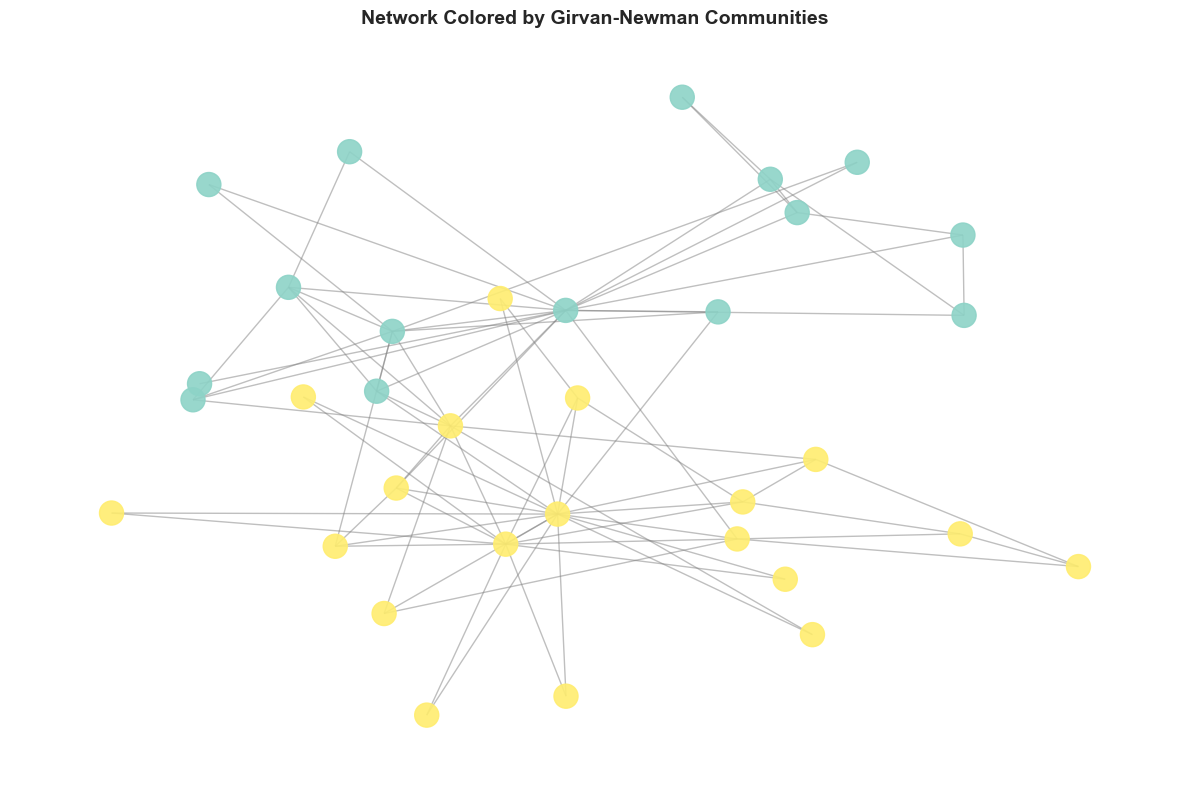

In [12]:
# Visualize Girvan-Newman communities
fig, ax, _ = plot_by_communities(G, girvan_newman_partition, pos=pos,
                                  title="Network Colored by Girvan-Newman Communities")
plt.show()


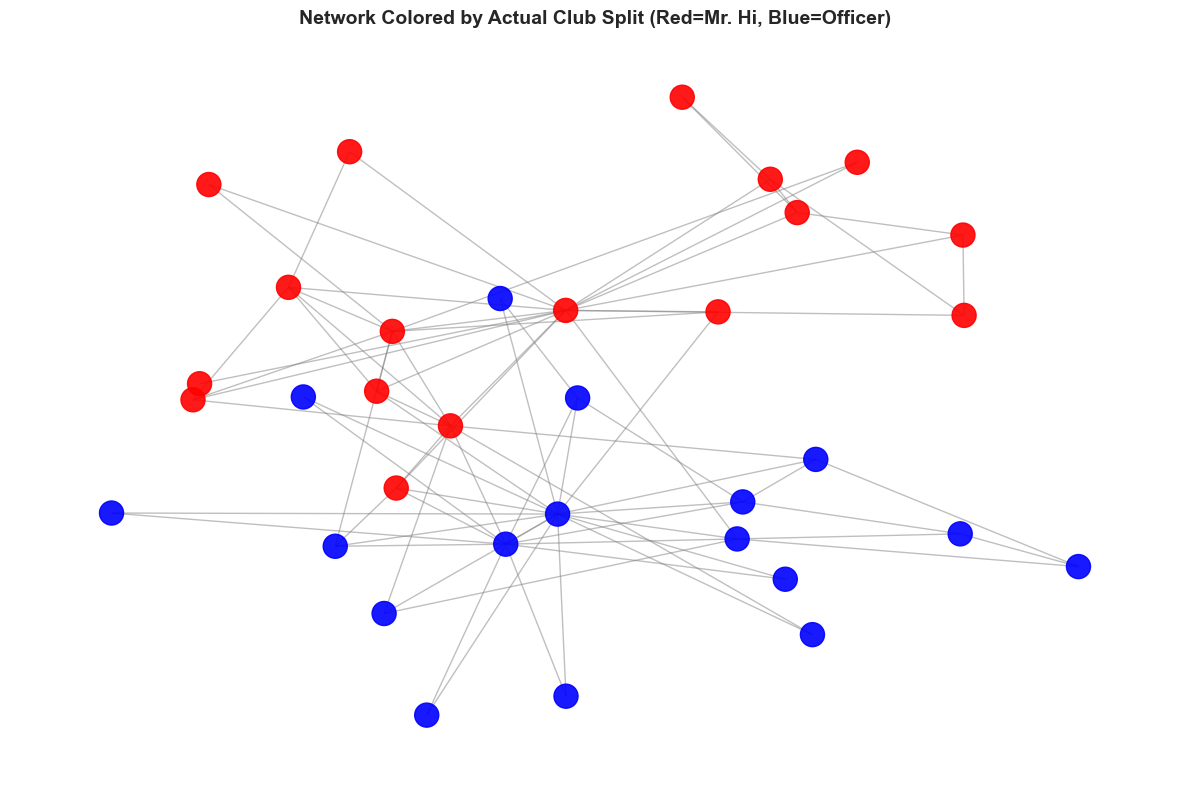

In [13]:
# Visualize actual club split for comparison
node_colors_actual = {node: 'red' if club_attribute.get(node) == 'Mr. Hi' else 'blue' 
                      for node in G.nodes()}
fig, ax, _ = plot_network(G, node_colors=node_colors_actual, pos=pos,
                          title="Network Colored by Actual Club Split (Red=Mr. Hi, Blue=Officer)")
plt.show()


## 6. Node Attribute-Based Clustering

We use KMeans clustering on node features (centrality measures + club attribute) to see if we can recover the faction structure.


In [14]:
# Prepare node features (centralities + club attribute)
features, node_list = prepare_node_features(G, centralities_df, attributes=club_numeric)

print(f"Feature matrix shape: {features.shape}")
print(f"Features: degree_centrality, betweenness_centrality, closeness_centrality, club_attribute")


Feature matrix shape: (34, 4)
Features: degree_centrality, betweenness_centrality, closeness_centrality, club_attribute


In [15]:
# KMeans clustering (2 clusters)
kmeans_labels, kmeans_model = kmeans_clustering(features, n_clusters=2, random_state=42)
kmeans_clusters = create_clustering_dict(node_list, kmeans_labels)

print("KMeans Clustering Results:")
print(f"Number of clusters: {len(set(kmeans_labels))}")

# Compare with actual split
cluster_counts = Counter(kmeans_labels)
print(f"\nCluster sizes: {dict(cluster_counts)}")

print("\n=== Comparison with Actual Split ===")
for cluster_id in sorted(set(kmeans_labels)):
    nodes_in_cluster = [node for node, cluster in kmeans_clusters.items() if cluster == cluster_id]
    mr_hi_count = sum(1 for node in nodes_in_cluster if club_attribute.get(node) == 'Mr. Hi')
    officer_count = sum(1 for node in nodes_in_cluster if club_attribute.get(node) == 'Officer')
    print(f"\nCluster {cluster_id} ({len(nodes_in_cluster)} nodes):")
    print(f"  Mr. Hi faction: {mr_hi_count}")
    print(f"  Officer faction: {officer_count}")
    print(f"  Purity: {max(mr_hi_count, officer_count) / len(nodes_in_cluster):.2%}")


KMeans Clustering Results:
Number of clusters: 2

Cluster sizes: {np.int32(1): 5, np.int32(0): 29}

=== Comparison with Actual Split ===

Cluster 0 (29 nodes):
  Mr. Hi faction: 15
  Officer faction: 14
  Purity: 51.72%

Cluster 1 (5 nodes):
  Mr. Hi faction: 2
  Officer faction: 3
  Purity: 60.00%


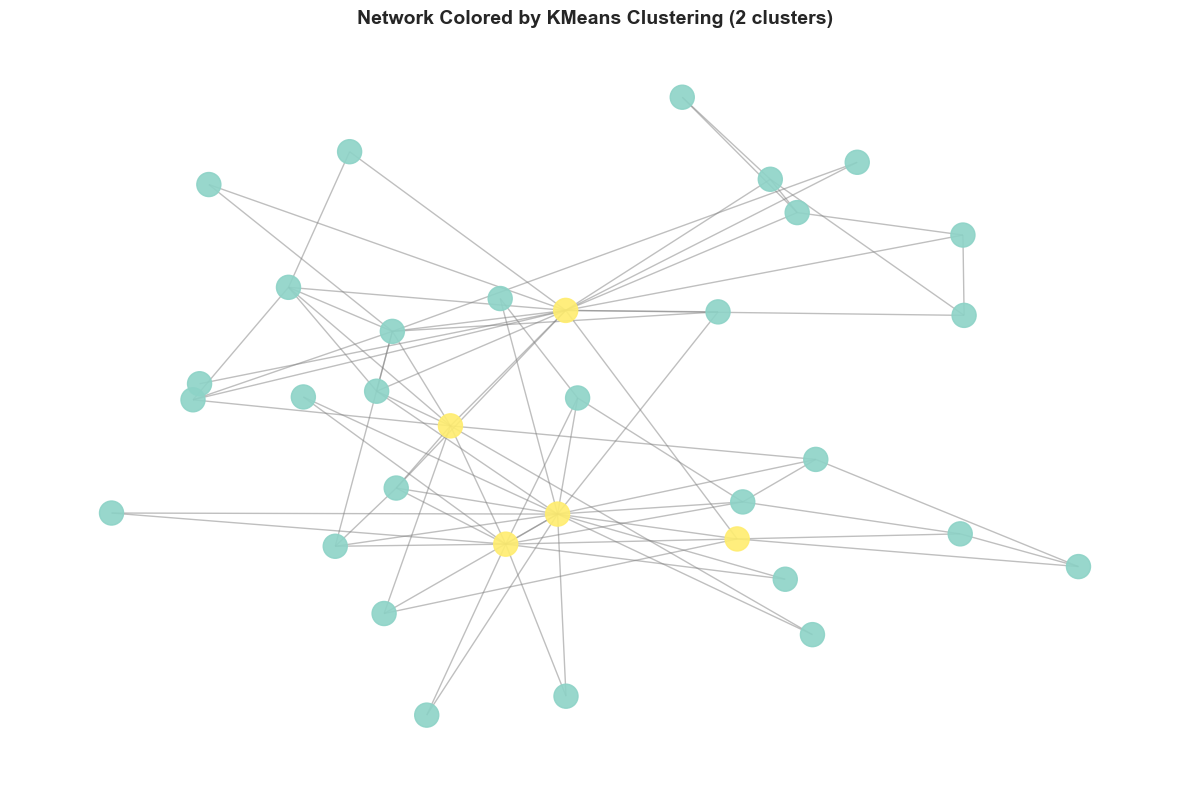

In [16]:
# Visualize KMeans clustering on network
fig, ax, _ = plot_by_communities(G, kmeans_clusters, pos=pos,
                                  title="Network Colored by KMeans Clustering (2 clusters)")
plt.show()


## 7. Dimensionality Reduction

We use MDS and t-SNE to visualize nodes in 2D space based on their structural features.


In [17]:
# MDS embedding
mds_embedding, mds_model = compute_mds_embedding(features, n_components=2, random_state=42)

print(f"MDS embedding shape: {mds_embedding.shape}")
print(f"Stress: {mds_model.stress_:.4f}")


MDS embedding shape: (34, 2)
Stress: 1.1190


C:\Users\dzmit\JOB\social_media_analysis\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


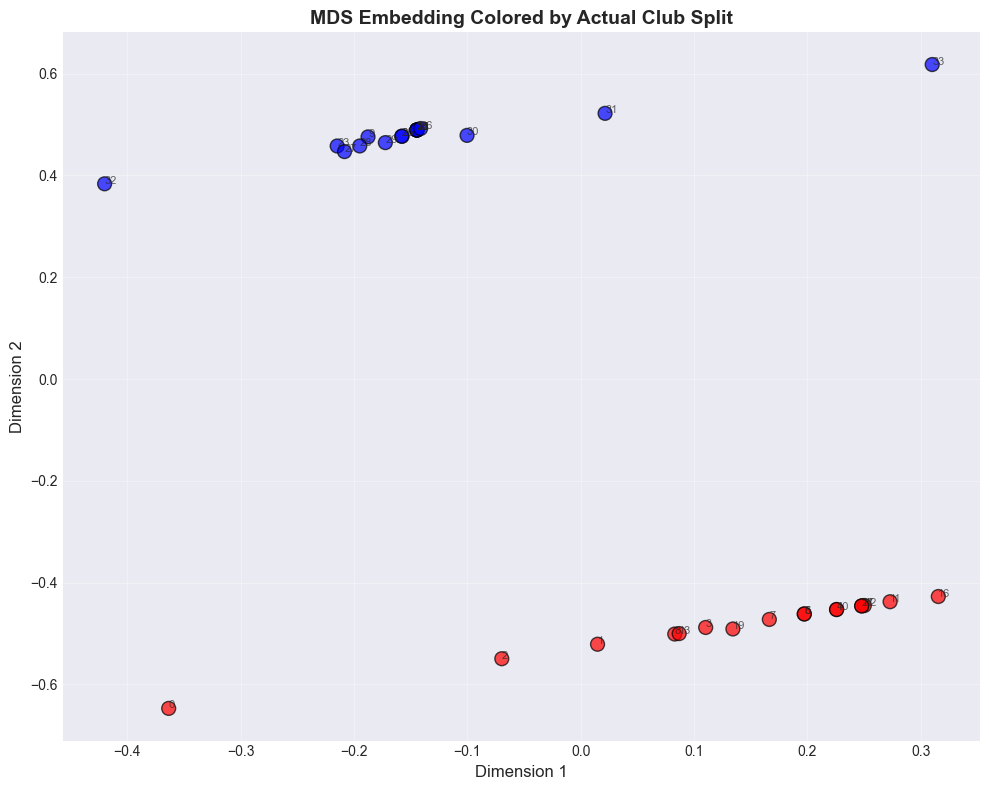

In [18]:
# Visualize MDS embedding colored by actual club split
fig, ax = plot_embedding(mds_embedding, labels=club_numeric, node_ids=node_list,
                         title="MDS Embedding Colored by Actual Club Split",
                         color_map={0: 'red', 1: 'blue'})
plt.show()


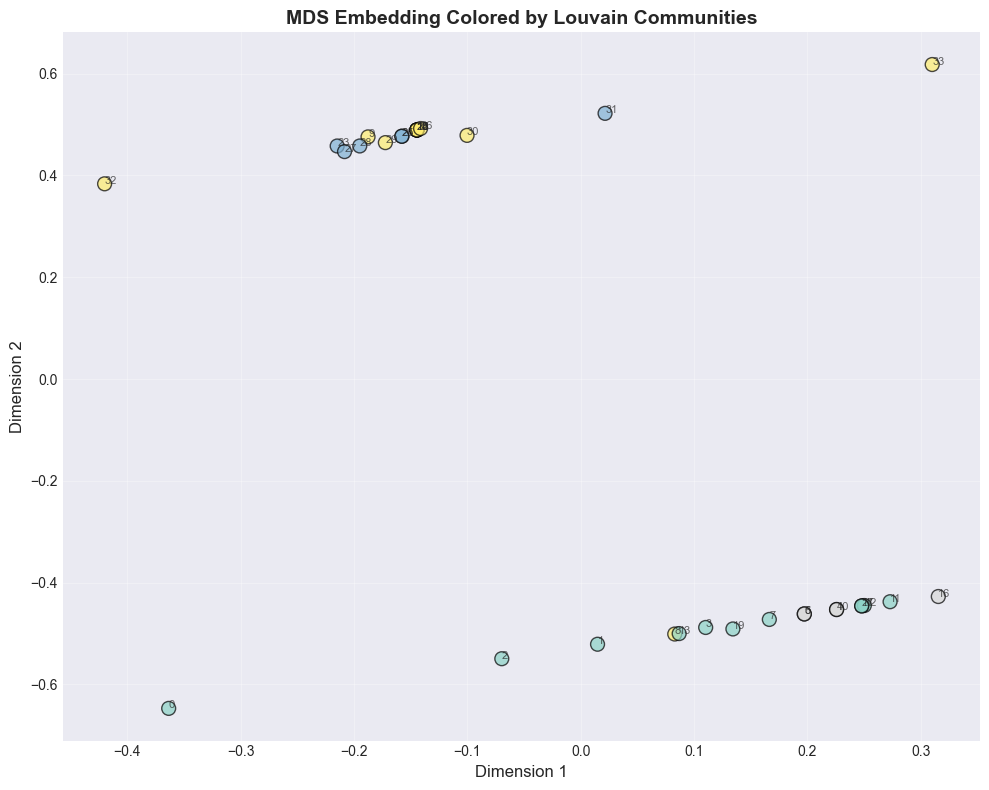

In [19]:
# Visualize MDS embedding colored by Louvain communities
fig, ax = plot_embedding(mds_embedding, labels=louvain_partition, node_ids=node_list,
                         title="MDS Embedding Colored by Louvain Communities")
plt.show()


In [20]:
# t-SNE embedding
tsne_embedding, tsne_model = compute_tsne_embedding(features, n_components=2, 
                                                    perplexity=5, random_state=42)

print(f"t-SNE embedding shape: {tsne_embedding.shape}")


t-SNE embedding shape: (34, 2)


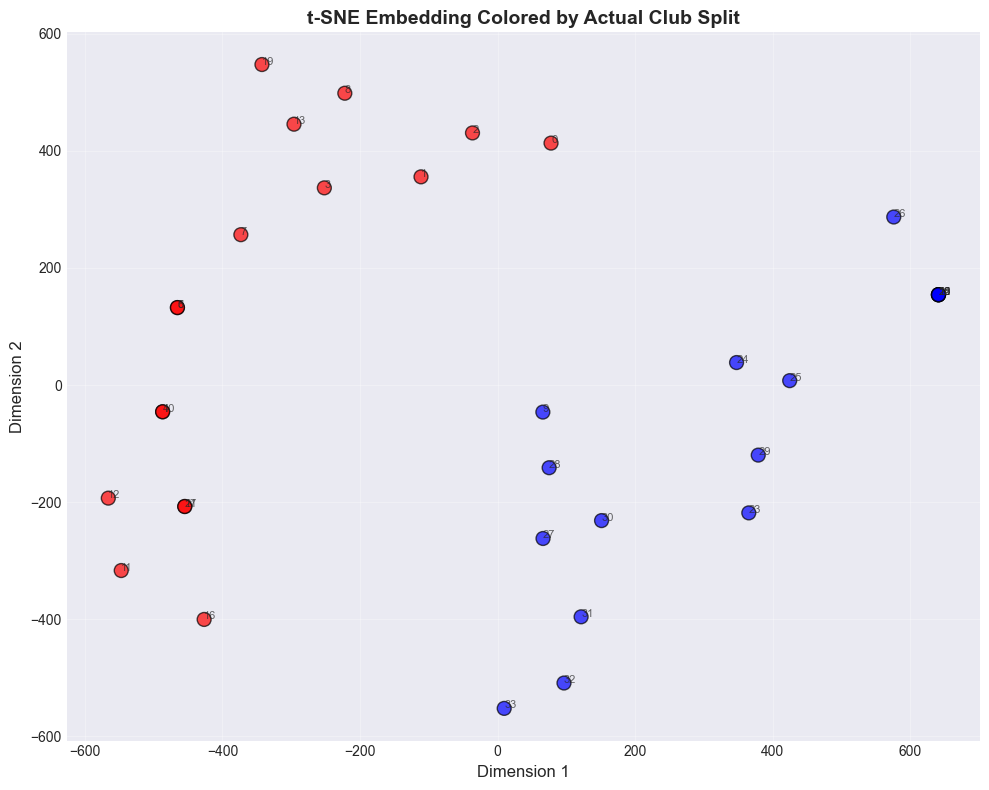

In [21]:
# Visualize t-SNE embedding colored by actual club split
fig, ax = plot_embedding(tsne_embedding, labels=club_numeric, node_ids=node_list,
                         title="t-SNE Embedding Colored by Actual Club Split",
                         color_map={0: 'red', 1: 'blue'})
plt.show()


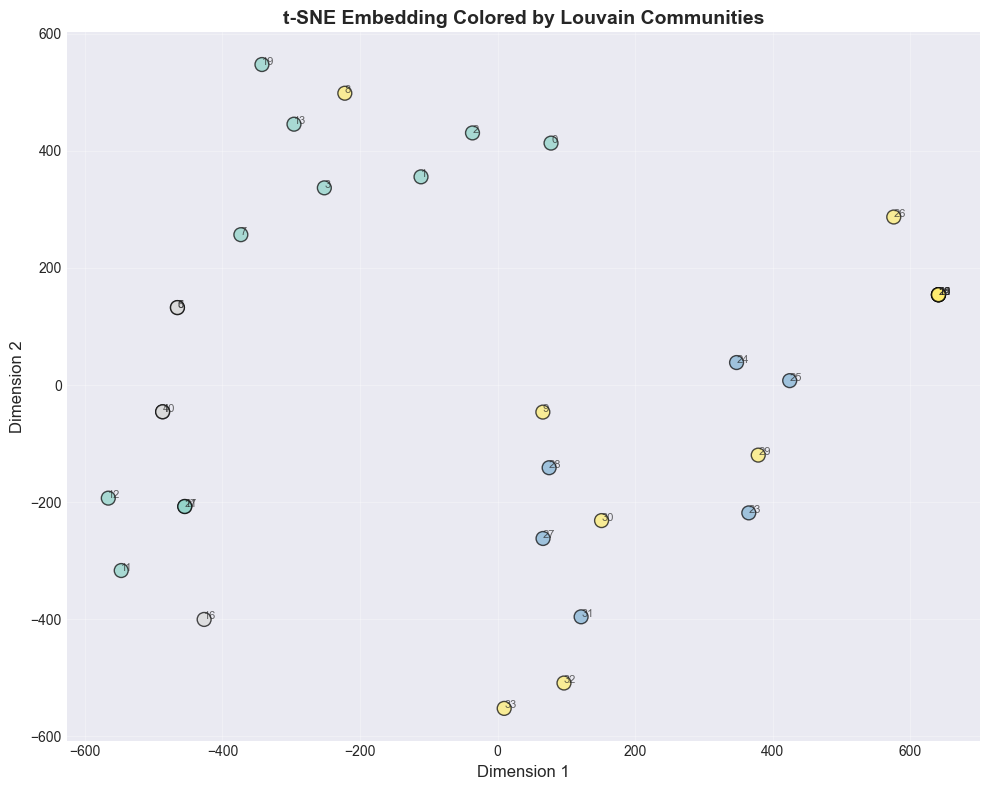

In [22]:
# Visualize t-SNE embedding colored by Louvain communities
fig, ax = plot_embedding(tsne_embedding, labels=louvain_partition, node_ids=node_list,
                         title="t-SNE Embedding Colored by Louvain Communities")
plt.show()


## 8. Comprehensive Visualization

Let's create a summary visualization comparing different community detection methods.


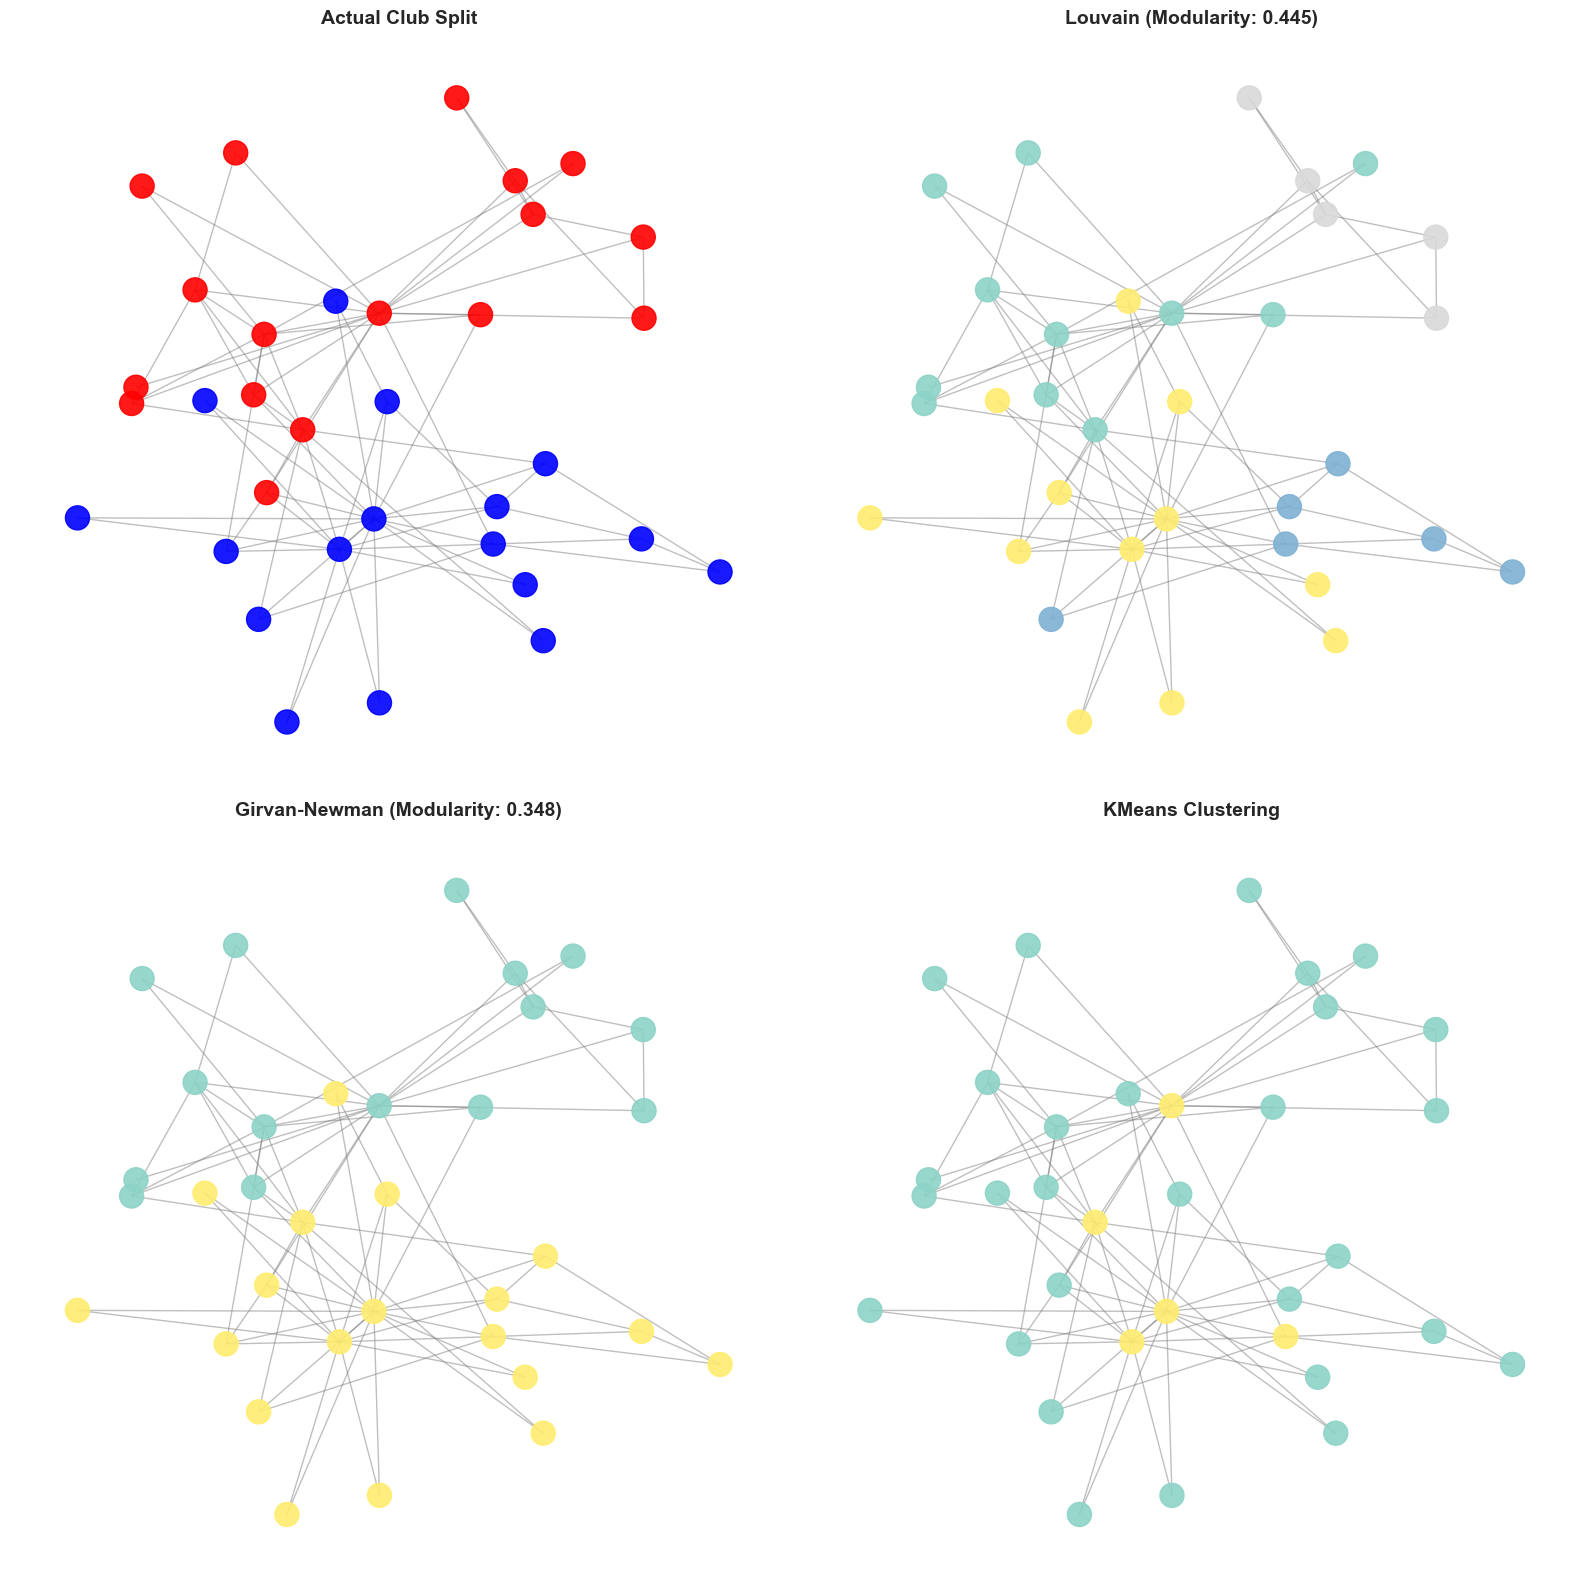

In [23]:
# Create a comprehensive comparison figure
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Actual split
node_colors_actual = {node: 'red' if club_attribute.get(node) == 'Mr. Hi' else 'blue' 
                      for node in G.nodes()}
plot_network(G, node_colors=node_colors_actual, pos=pos, 
             title="Actual Club Split", ax=axes[0, 0], node_labels=False)

# Louvain
plot_by_communities(G, louvain_partition, pos=pos,
                    title=f"Louvain (Modularity: {louvain_modularity:.3f})", 
                    ax=axes[0, 1])

# Girvan-Newman
plot_by_communities(G, girvan_newman_partition, pos=pos,
                    title=f"Girvan-Newman (Modularity: {girvan_modularity:.3f})", 
                    ax=axes[1, 0])

# KMeans
plot_by_communities(G, kmeans_clusters, pos=pos,
                    title="KMeans Clustering", 
                    ax=axes[1, 1])

plt.tight_layout()
plt.show()


## 9. Conclusions

### Key Findings:

1. **Centrality Analysis:**
   - Nodes with high degree centrality represent key connectors in the network
   - Betweenness centrality identifies nodes that act as bridges between different parts of the network
   - Closeness centrality highlights nodes that can quickly reach all other members

2. **Community Detection:**
   - Both Louvain and Girvan-Newman algorithms successfully identify the two main factions
   - The detected communities align well with the actual split that occurred
   - Louvain algorithm achieved higher modularity, indicating better community structure

3. **Attribute-Based Clustering:**
   - KMeans clustering on node features (centrality + club attribute) can recover the faction structure
   - Structural properties combined with known attributes provide a good basis for clustering

4. **Dimensionality Reduction:**
   - MDS and t-SNE embeddings reveal the underlying structure of the network
   - Nodes from the same faction tend to cluster together in the embedded space
   - The visualization confirms the separation between the two groups

### Answer to Research Question:

The analysis confirms that:
- **Most central nodes** (e.g., nodes with highest degree/betweenness) correspond to key individuals in the network
- **Detected communities** align remarkably well with the actual split, demonstrating the power of network analysis methods
- The **structural properties** of the network contain enough information to predict the faction split

### Limitations and Future Work:

- The dataset is small (34 nodes), which limits statistical power
- Different algorithms may perform differently on larger networks
- Additional node attributes could be incorporated for more sophisticated analysis


## 10. References

1. **Zachary, W. W.** (1977). An information flow model for conflict and fission in small groups. *Journal of anthropological research*, 33(4), 452-473.

2. **SNAP Dataset Repository:** Zachary's Karate Club Network. Stanford Network Analysis Project. Retrieved from: https://snap.stanford.edu/data/ego-Zachary.html

3. **NetworkX Documentation:** NetworkX — NetworkX documentation. Retrieved from: https://networkx.org/

4. **Blondel, V. D., et al.** (2008). Fast unfolding of communities in large networks. *Journal of statistical mechanics: theory and experiment*, 2008(10), P10008.

5. **Girvan, M., & Newman, M. E. J.** (2002). Community structure in social and biological networks. *Proceedings of the national academy of sciences*, 99(12), 7821-7826.

6. **Van der Maaten, L., & Hinton, G.** (2008). Visualizing data using t-SNE. *Journal of machine learning research*, 9(Nov), 2579-2605.

---

*End of Analysis*
